In [1]:
from gmail_agent import Gmail_agent
from calendar_agent import Calendar_agent
from maps_agent import Maps_agent
from contacts_agent import Contacts_agent
from tasks_agent import Tasks_agent
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool,Tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    
)
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import RetryOutputParser
from langgraph.types import Command

from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_core.tools.base import InjectedToolCallId
from pydantic import BaseModel,Field

from typing_extensions import TypedDict
from typing import Annotated, List

import os
from dotenv import load_dotenv 

#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
import requests
import gradio as gr

c:\Users\padio\Desktop\important\AI portfolio\Google_AI_Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from token_creator import get_creds
get_creds()

' token available '

In [3]:
load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')
pse=os.getenv('pse')

In [4]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [5]:
mail_agent=Gmail_agent(llm)
calendar_agent=Calendar_agent(llm)
maps_agent=Maps_agent(llm)
tasks_agent=Tasks_agent(llm)
contacts_agent=Contacts_agent(llm)

In [6]:
class State(TypedDict):
    node_messages: Annotated[List, add_messages]
    query: str
    plan: List
    num_retries: int
    node_query:str

In [7]:
class ManagerCapability(BaseModel):
    """Represents a specific capability that a manager tool provides"""
    action: str = Field(..., description="The specific action that can be performed")
    description: str = Field(None, description="Optional description of what this capability does")

class ManagerTool(BaseModel):
    """Represents a manager tool and its capabilities"""
    name: str = Field(..., description="The name of the manager tool")
    tool_function: str = Field(..., description="The function name used to call this tool")
    description: str = Field(..., description="General description of what this tool does")
    capabilities: List[ManagerCapability] = Field(..., description="List of capabilities this tool provides")



class ManagerTools(BaseModel):
    """Collection of all available manager tools and their capabilities"""
    managers: List[ManagerTool] = Field(
        default=[
            ManagerTool(
                name="Maps Manager",
                tool_function="maps_manager",
                description="Tool to use to answer maps and location queries",
                capabilities=[
                    ManagerCapability(action="find locations", description="Such as restaurants, bowling alleys, museums and others"),
                    ManagerCapability(action="display location info", description="Shows address, name, URL, price range")
                ]
            ),
            ManagerTool(
                name="Google images tool",
                tool_function="google_image_tool",
                description="Tool to use to get images",
                capabilities=[
                    ManagerCapability(action="get image", description="returns a url of the image"),
                ]),
            ManagerTool(
                name="Contacts Manager",
                tool_function="contacts_manager",
                description="Tool to use to answer queries about a contact or a person",
                capabilities=[
                    ManagerCapability(action="list contacts", description="Shows all available contacts"),
                    ManagerCapability(action="get contact details", description="Retrieves information about a specific contact, like email addresses"),
                    ManagerCapability(action="delete contact", description="Removes a contact from the list"),
                    ManagerCapability(action="create contact", description="Adds a new contact to the list"),
                    ManagerCapability(action="modify contact", description="Updates information for an existing contact")
                ]
            ),
            ManagerTool(
                name="Tasks Manager",
                tool_function="tasks_manager",
                description="Tool to use to answer task related queries",
                capabilities=[
                    ManagerCapability(action="list tasks", description="Shows all available tasks"),
                    ManagerCapability(action="create task", description="Adds a new task"),
                    ManagerCapability(action="get task details", description="Retrieves information about a specific task"),
                    ManagerCapability(action="complete task", description="Marks a task as completed and deletes it")
                ]
            ),
            ManagerTool(
                name="Mail Manager",
                tool_function="mail_manager",
                description="Tool to use to answer any email related queries",
                capabilities=[
                    ManagerCapability(action="get new mail", description="Checks for new emails"),
                    ManagerCapability(action="show inbox", description="Displays all emails in the inbox"),
                    ManagerCapability(action="get mail content", description="Retrieves the content of a specific email"),
                    ManagerCapability(action="create email", description="Composes a new email using the email adress"),
                    ManagerCapability(action="verify email content", description="Checks the content of an email"),
                    ManagerCapability(action="send email", description="Sends a composed email")
            
                ]
            ),
            ManagerTool(
                name="Calendar Manager",
                tool_function="calendar_manager",
                description="Tool to use to answer any calendar or schedule related queries",
                capabilities=[
                    ManagerCapability(action="create recurring events", description="Sets up events that repeat on a schedule"),
                    ManagerCapability(action="create quick events", description="Quickly adds a one-time event"),
                    ManagerCapability(action="refresh calendar", description="Updates the calendar with latest information"),
                    ManagerCapability(action="show calendar", description="Displays the calendar view")
                ]
            )
        ],
        description="The complete list of available manager tools"
    )
    

In [8]:
manager_tools = ManagerTools()

# For Pydantic V2 
manager_dict = manager_tools.model_dump()

In [9]:
manager_dict

{'managers': [{'name': 'Maps Manager',
   'tool_function': 'maps_manager',
   'description': 'Tool to use to answer maps and location queries',
   'capabilities': [{'action': 'find locations',
     'description': 'Such as restaurants, bowling alleys, museums and others'},
    {'action': 'display location info',
     'description': 'Shows address, name, URL, price range'}]},
  {'name': 'Google images tool',
   'tool_function': 'google_image_tool',
   'description': 'Tool to use to get images',
   'capabilities': [{'action': 'get image',
     'description': 'returns a url of the image'}]},
  {'name': 'Contacts Manager',
   'tool_function': 'contacts_manager',
   'description': 'Tool to use to answer queries about a contact or a person',
   'capabilities': [{'action': 'list contacts',
     'description': 'Shows all available contacts'},
    {'action': 'get contact details',
     'description': 'Retrieves information about a specific contact, like email addresses'},
    {'action': 'delete 

In [10]:
def planner_node(state: State):
    class task_shema(BaseModel):
        task: str = Field(description='description of the task')
        manager_tool: str = Field(description= 'the name of the manager tool to use')
        action: str = Field(description=' the action that the manager tool must take')
    class plan_shema(BaseModel):
        tasks: List[task_shema] = Field(description='the list of tasks that the agent need to complete to succesfully complete the query')
    parser=JsonOutputParser(pydantic_object=plan_shema)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    
    chain = prompt | llm 
    try:
        response=chain.invoke({'query':f'based on this query: {state['query']} generate a plan using those manager tools: {manager_dict} to get the necessary info and to complete the query, the plan cannot contain more than 10 tasks'}) 
        try:
            response=parser.parse(response.content)
            
            return {'plan':response.get('tasks')}
        except:
            try:
                retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

                prompt_value = prompt.format_prompt(query=state['query'])
                response=retry_parser.parse_with_prompt(response.content, prompt_value) 
        
               
                return {'plan':response.get('tasks')}
            except:
                return {'route':'END'}
    except:
                return {'route':'END'}


In [ ]:
def agent_node(state: State):
    class task_route(BaseModel):
        node_query: str = Field(description='the query to be passed to one of the manager tool nodes')
        route: str = Field (description='the name of the manager tool to use or if finished END')
    plan= state.get('plan')
    

    
    # node_messages=state.get('node_messages')
    parser=JsonOutputParser(pydantic_object=task_route)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    
    chain = prompt | llm 
    if plan:
        response=chain.invoke({'query':f'based on this task: {plan[0]} generate a query to be passed to the manager_tool mentionned in the task, use the informations from previous nodes {state.get('node_messages')}, if there are no tasks left return END'}) 
    try:
        response=parser.parse(response.content)
        
        return {'node_query':response.get('node_query'),
                'route':response.get('route')}
    except:
        try:
            retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

            prompt_value = prompt.format_prompt(query=state['query'])
            response=retry_parser.parse_with_prompt(response.content, prompt_value) 
            
            return {'node_query':response.get('node_query'),
                'route':response.get('route')}
        except:
            return {'route':'END'}
    

In [12]:
def router(state: State):
    route=state.get('route')
    routing_map = {
        'Maps Manager': 'to_maps_manager',
        'Google images tool': 'to_google_image_tool',
        'Contacts Manager': 'to_contact_manager',
        'Tasks Manager': 'to_tasks_manager',
        'Mail Manager': 'to_mail_manager',
        'Calendar Manager': 'to_calendar_manager',
        'END':'to_end'
    }
    return routing_map.get(route)

In [13]:
def evaluator_node(state: State):
    node_message=state.get('node_messages')
    
    class Status(BaseModel):
        status: str = Field(description='completed or failed')
    parser=JsonOutputParser(pydantic_object=Status)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    
    chain = prompt | llm 
    try:
        response=chain.invoke({'query':f'based on this node message: {node_message[-1].content} and the prompt: {state.get('node_query')}, decide if the task was completed or failed '}) 
       
        response=parser.parse(response.content)
            
    except:
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value) 
        
    status=response.get('status')          
               
    
    if status =='failed':
        if state.get('num_retries')<2:
            return {'num_retries': state.get('num_retries')+1}
        else:
            plan=state.get('plan')
            del plan[0]
            return {'num_retries':0,
                    'plan':plan}
    else:
        plan=state.get('plan')
        del plan[0]
        return {'num_retries':0,
                'plan':plan}

In [14]:
store=InMemoryStore()

In [15]:
def google_image_search_node(state:State):
  """Search for images using Google Custom Search API
  args: query
  return: image url
  """
  # Define the API endpoint for Google Custom Search
  url = "https://www.googleapis.com/customsearch/v1"
  query=state.get('node_query')

  params = {
      "q": query,
      "cx": pse,
      "key": GOOGLE_API_KEY,
      "searchType": "image",  # Search for images
      "num": 1  # Number of results to fetch
  }

  # Make the request to the Google Custom Search API
  response = requests.get(url, params=params)
  data = response.json()

  # Check if the response contains image results
  if 'items' in data:
      # Extract the first image result
      image_url = data['items'][0]['link']
      return {'node_messages':f' here is the url for the image {image_url}'}
  else:
      return {'node_messages':'failed'}



In [16]:
def contacts_manager_node(state: State):
    """use this tool to answer queries about a contact or a person
    this tool can:
    list my contacts
    get a contact's details
    delete a contact
    create a contact
    modify a contact
    args: query - pass the entire contacts related queries directly here
    """
    response=contacts_agent.chat(state.get('node_query'))
    # return response
    return {'node_messages':[AIMessage(f'{response}')]}

In [17]:

def tasks_manager_node(state: State):
    """use this tool to answer task related queries
    this tool can:
    list tasks
    create tasks
    get task details
    complete a task (which also deletes it :) )

    args: query - pass the entire tasks related queries directly here
    
    """


    response=tasks_agent.chat(state.get('node_query'))
    # return response
    return {'node_messages':[AIMessage(f'{response}')]}

In [18]:
def maps_manager_node(state: State):
    """tool to use to answer maps and location queries
    this tool can:
    find locations such as restorants, bowling alleys, museums and others
    display those locations's infos (eg. adress, name, url, price range)
    args: query - pass the maps or loc related queries directly here
    return: locations with urls
    """
    response=maps_agent.chat(state.get('node_query'))
    # return response
    return {'node_messages':[AIMessage(f'{response}')]}

In [19]:

def mail_manager_node(state: State):
    """Tool to use to answer any email related queries
    this tool can:
    get new mail
    show the inbox
    get a specific mail's content to display
    create a draft of a new mail
    create an email
    verify the email content
    send the email
    list all the drafts
    args: query - pass the email related queries directly here
    """
    response=mail_agent.chat(state.get('node_query'))
    # return response
    return {'node_messages':[AIMessage(f'{response}')]}

In [20]:

def calendar_manager_node(state: State):
    """tool to use to answere any calendar or schedule related queries
    this tool can:
    create recuring events
    create quick events
    refresh the calendar
    show the calendar
    args: query - pass the entire calendar related queries directly here
    """
    response=calendar_agent.chat(state.get('node_query'))
    # return response
    return {'node_messages':[AIMessage(f'{response}')]}

In [21]:
class google_agent:
    def __init__(self,llm: any):
        self.agent=self._setup(llm)
    def _setup(self,llm):
   
        graph_builder = StateGraph(State)

        # Modification: tell the LLM which tools it can call

        graph_builder.add_node("planner", planner_node)
        graph_builder.add_node('calendar_manager', calendar_manager_node)
        graph_builder.add_node('mail_manager',mail_manager_node)
        graph_builder.add_node('tasks_manager',tasks_manager_node)
        graph_builder.add_node('contacts_manager',contacts_manager_node)
        graph_builder.add_node('maps_manager',maps_manager_node)
        graph_builder.add_node('google_image_tool',google_image_search_node)
        graph_builder.add_node('evaluator', evaluator_node)
        
        graph_builder.add_node("agent", agent_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.add_edge(START,'planner')
        graph_builder.add_edge("planner", "agent")
        graph_builder.add_edge("maps_manager", "evaluator")
        graph_builder.add_edge('tasks_manager','evaluator')
        graph_builder.add_edge('mail_manager','evaluator')
        graph_builder.add_edge('google_image_tool','evaluator')
        graph_builder.add_edge('contacts_manager','evaluator')
        graph_builder.add_edge('calendar_manager','evaluator')
        graph_builder.add_edge('evaluator', 'agent')
        graph_builder.add_conditional_edges(
            "agent",
            router,{
            'to_maps_manager': 'maps_manager',
            'to_google_image_tool': 'google_image_tool',
            'to_contact_manager': 'contacts_manager',
            'to_tasks_manager': 'tasks_manager',
            'to_mail_manager': 'mail_manager',
            'to_calendar_manager': 'calendar_manager',
            'to_end': END
            }
        )
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory,store=store)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input,
                                    'num_retries':0},config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input,
                                        'num_retries':0}, config, stream_mode="updates"):
            print(event)
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

In [22]:
agent=google_agent(llm)

In [23]:
agent.stream('get an image of a blue cat and send it to tristan padious email address')

{'planner': {'plan': [{'task': 'Get the email address of Tristan Padious.', 'manager_tool': 'Contacts Manager', 'action': 'get contact details'}, {'task': 'Get an image of a blue cat.', 'manager_tool': 'Google images tool', 'action': 'get image'}, {'task': 'Create an email to Tristan Padious with the image of the blue cat.', 'manager_tool': 'Mail Manager', 'action': 'create email'}, {'task': 'Send the email to Tristan Padious.', 'manager_tool': 'Mail Manager', 'action': 'send email'}]}}
{'agent': {'node_query': 'email address of Tristan Padious'}}
{'contacts_manager': {'node_messages': [AIMessage(content="{'query': 'email address of Tristan Padious', 'contacts': {'Tristan Padiou': {'resourcename': 'people/c1444037682365792704', 'etag': '%EgUBAi43PRoEAQIFByIMVkV1eDhZS1d6WUE9'}, 'Giselle Bogs': {'resourcename': 'people/c773801861794169656', 'etag': '%EgUBAi43PRoEAQIFByIMQ2J5RjZJWWxHc3M9'}, 'pascale padiou': {'resourcename': 'people/c9136797831542164705', 'etag': '%EgUBAi43PRoEAQIFByIMN1c

IndexError: list index out of range

In [ ]:
messages=agent.get_state(state_val='query')

ValueError: Message dict must contain 'role' and 'content' keys, got {'query': 'email address of Tristan Padious', 'contacts': {'Tristan Padiou': {'resourcename': 'people/c1444037682365792704', 'etag': '%EgUBAi43PRoEAQIFByIMVkV1eDhZS1d6WUE9'}, 'Giselle Bogs': {'resourcename': 'people/c773801861794169656', 'etag': '%EgUBAi43PRoEAQIFByIMQ2J5RjZJWWxHc3M9'}, 'pascale padiou': {'resourcename': 'people/c9136797831542164705', 'etag': '%EgUBAi43PRoEAQIFByIMN1cxbFQzOXI1c0U9'}, 'Johnny Doe': {'resourcename': 'people/c7610783302568859438', 'etag': '%EgUBAi43PRoEAQIFByIMak5sN0tJcitYeWM9'}}, 'contact_details': {'resourceName': 'people/c1444037682365792704', 'etag': '%Eg0BAgUHCQsQLjc9Pj9AGgQBAgUHIgxWRXV4OFlLV3pZQT0=', 'names': [{'metadata': {'primary': True, 'source': {'type': 'CONTACT', 'id': '140a409f0bb101c0'}, 'sourcePrimary': True}, 'displayName': 'Tristan Padiou', 'familyName': 'Padiou', 'givenName': 'Tristan', 'displayNameLastFirst': 'Padiou, Tristan', 'unstructuredName': 'Tristan Padiou'}], 'addresses': [{'metadata': {'primary': True, 'source': {'type': 'CONTACT', 'id': '140a409f0bb101c0'}}, 'formattedValue': '524w 19th st\napt 4 e, NYC, NY 10011\nUSA', 'type': 'home', 'formattedType': 'Home', 'streetAddress': '524w 19th st', 'extendedAddress': 'apt 4 e', 'city': 'NYC', 'region': 'NY', 'postalCode': '10011', 'country': 'USA'}], 'emailAddresses': [{'metadata': {'primary': True, 'source': {'type': 'CONTACT', 'id': '140a409f0bb101c0'}, 'sourcePrimary': True}, 'value': 'padioutristan@gmail.com', 'type': 'other', 'formattedType': 'Other', 'displayName': 'padioutristan@gmail.com'}]}, 'route': 'get_contact_details'}
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 

In [ ]:
contacts_agent.get_state('contact_details')

{'resourceName': 'people/c1444037682365792704',
 'etag': '%Eg0BAgUHCQsQLjc9Pj9AGgQBAgUHIgxWRXV4OFlLV3pZQT0=',
 'names': [{'metadata': {'primary': True,
    'source': {'type': 'CONTACT', 'id': '140a409f0bb101c0'},
    'sourcePrimary': True},
   'displayName': 'Tristan Padiou',
   'familyName': 'Padiou',
   'givenName': 'Tristan',
   'displayNameLastFirst': 'Padiou, Tristan',
   'unstructuredName': 'Tristan Padiou'}],
 'addresses': [{'metadata': {'primary': True,
    'source': {'type': 'CONTACT', 'id': '140a409f0bb101c0'}},
   'formattedValue': '524w 19th st\napt 4 e, NYC, NY 10011\nUSA',
   'type': 'home',
   'formattedType': 'Home',
   'streetAddress': '524w 19th st',
   'extendedAddress': 'apt 4 e',
   'city': 'NYC',
   'region': 'NY',
   'postalCode': '10011',
   'country': 'USA'}],
 'emailAddresses': [{'metadata': {'primary': True,
    'source': {'type': 'CONTACT', 'id': '140a409f0bb101c0'},
    'sourcePrimary': True},
   'value': 'padioutristan@gmail.com',
   'type': 'other',
   'f

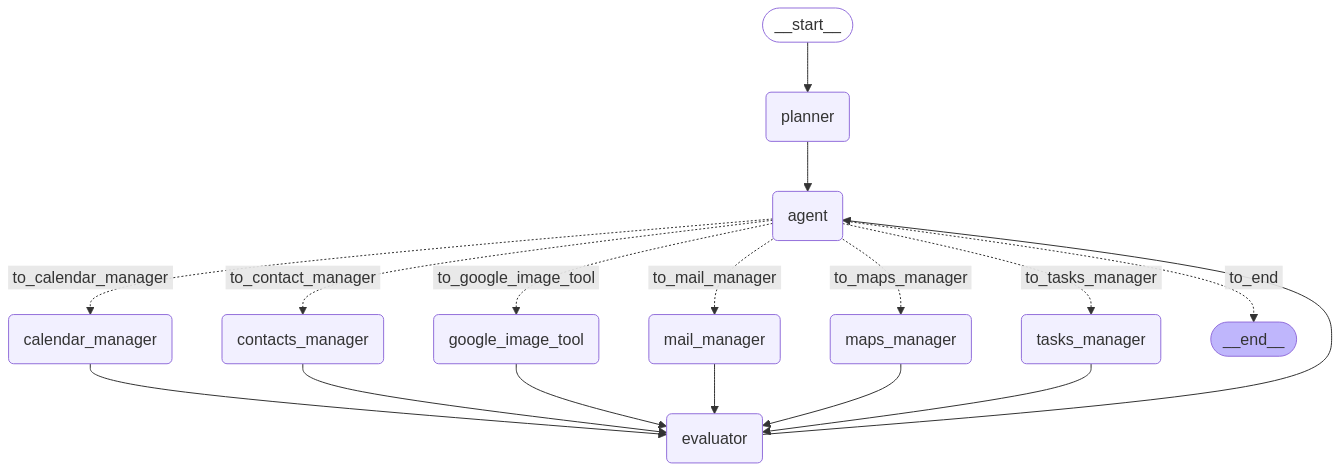

In [ ]:
agent.display_graph()

In [ ]:
# class google_agent:
#     def __init__(self,llm: any):
#         self.agent=self._setup(llm)
#     def _setup(self,llm):
   
#         langgraph_tools=[mail_manager,calendar_manager,maps_manager, tasks_manager, contacts_manager, google_image_tool]



#         graph_builder = StateGraph(State)

#         # Modification: tell the LLM which tools it can call
#         llm_with_tools = llm.bind_tools(langgraph_tools)
#         tool_node = ToolNode(tools=langgraph_tools)
#         def chatbot(state: State):
#             """ google ai agent, that can interact with contacts, emails, maps, tasks and calendar.
#             Depending on the request, leverage which tools to use if necessary."""
#             return {"messages": [llm_with_tools.invoke(state['messages'])]}

#         graph_builder.add_node("chatbot", chatbot)

        
#         graph_builder.add_node("tools", tool_node)
#         # Any time a tool is called, we return to the chatbot to decide the next step
#         graph_builder.add_edge(START,'chatbot')
#         graph_builder.add_edge("tools", "chatbot")
#         graph_builder.add_conditional_edges(
#             "chatbot",
#             tools_condition,
#         )
#         memory=MemorySaver()
#         graph=graph_builder.compile(checkpointer=memory,store=store)
#         return graph
        

#     def display_graph(self):
#         return display(
#                         Image(
#                                 self.agent.get_graph().draw_mermaid_png(
#                                     draw_method=MermaidDrawMethod.API,
#                                 )
#                             )
#                         )
#     def stream(self,input:str):
#         config = {"configurable": {"thread_id": "1"}}
#         input_message = HumanMessage(content=input)
#         for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
#             event["messages"][-1].pretty_print()

#     def chat(self,input:str):
#         config = {"configurable": {"thread_id": "1"}}
#         response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
#         return response['messages'][-1].content
    
#     def get_state(self, state_val:str):
#         config = {"configurable": {"thread_id": "1"}}
#         return self.agent.get_state(config).values[state_val]

In [ ]:
agent=google_agent(llm)

In [ ]:
def chatbot(input,history):
    response=agent.chat(input)
    return response


In [ ]:
demo = gr.ChatInterface(chatbot, type="messages", autofocus=False)

if __name__ == "__main__":
    demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [ ]:
contacts_agent.get_state('messages')

KeyError: 'messages'